# **Data Augmentation**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
!python --version

2.6.0
Python 3.7.11


## Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"train data shape: {x_train.shape}")
print(f"label train shape: {y_train.shape}")
print(f"test data shape: {x_test.shape}")
print(f"label test shape: {y_test.shape}")

170508288/170498071 [==============================] - 2s 0us/step
train data shape: (50000, 32, 32, 3)
label train shape: (50000, 1)
test data shape: (10000, 32, 32, 3)
label test shape: (10000, 1)


In [3]:
num_classes = 10

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(f"label train shape: {y_train.shape}")
print(f"label test shape: {y_test.shape}")

label train shape: (50000, 10)
label test shape: (10000, 10)


## Data Augmentation Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_generator_aug():
    data_generator_aug = ImageDataGenerator(rescale=(1/255.0),
                                       rotation_range=35,
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       fill_mode='nearest',
                                       brightness_range=(0.2,0.8),
                                       shear_range=45.0,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=[0.5, 1.5])
    return data_generator_aug

In [5]:
data_generator_aug = get_generator_aug()
data_generator_aug.fit(x_train)
train_generator_aug = data_generator_aug.flow(x_train, y_train, batch_size=10, shuffle=True)

data_generator_aug_test = get_generator_aug()
data_generator_aug_test.fit(x_test)
test_generator_aug = data_generator_aug_test.flow(x_test, y_test, batch_size=10, shuffle=True)

In [6]:
data_generator = ImageDataGenerator(rescale=(1/255.0))
data_generator.fit(x_train)
img_generator = data_generator.flow(x_train, y_train, batch_size=10, shuffle=False)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


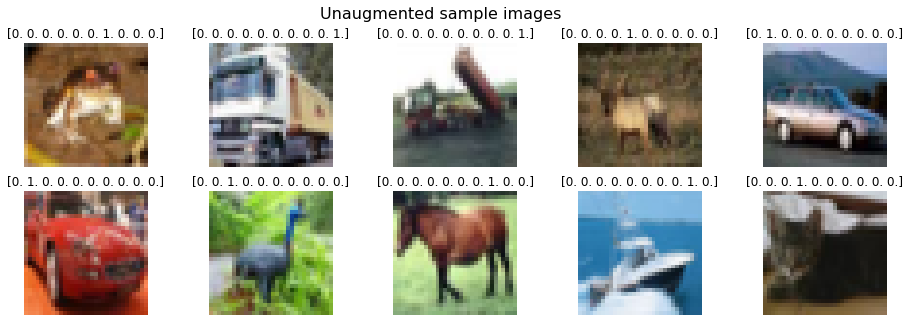

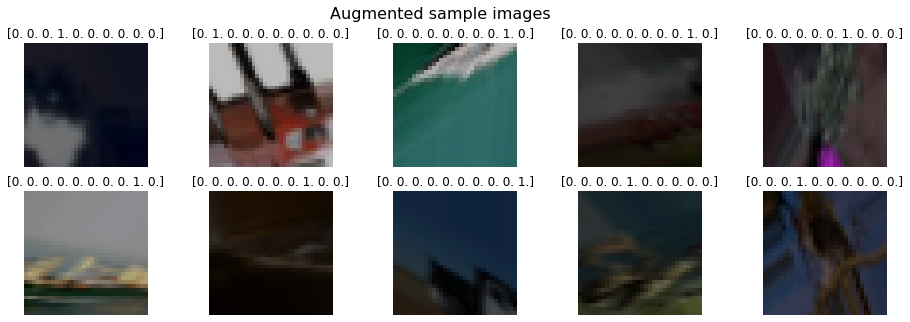

In [7]:
img, label = next(img_generator)
img_aug, label_aug = next(train_generator_aug)

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented sample images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(img[i,...])
    plt.title(label[i])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented sample images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(img_aug[i,...])
    plt.title(label_aug[i])
    plt.axis('off')

## Create Model

In [22]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def get_model(input_shape):
    input_layer = Input(input_shape)
    layer1 = Conv2D(32, 8, activation="relu", padding="SAME")(input_layer)
    layer2 = MaxPooling2D((2,2))(layer1)
    layer3 = Conv2D(32, 4, activation="relu", padding="SAME")(layer2)
    layer4 = MaxPooling2D((2,2))(layer3)
    layer5 = Flatten()(layer4)
    layer6 = Dense(16, activation="relu")(layer5)
    output_layer = Dense(10, activation="softmax")(layer6) 
    
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                 loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

In [23]:
model = get_model(input_shape = (32,32,3))
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        6176      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 32)        16416     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                3278

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
    
train_steps_per_epoch = img_generator.n // img_generator.batch_size
    
history = model.fit(img_generator, steps_per_epoch=train_steps_per_epoch,
                  validation_data=(x_test, y_test),
                  epochs=20,
                  callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=5)])

Epoch 1/20
5000/5000 [==============================] - 30s 6ms/step - loss: 1.8453 - categorical_accuracy: 0.3432 - val_loss: 165.9116 - val_categorical_accuracy: 0.4119
Epoch 2/20
5000/5000 [==============================] - 29s 6ms/step - loss: 1.5658 - categorical_accuracy: 0.4448 - val_loss: 172.2222 - val_categorical_accuracy: 0.4382
Epoch 3/20
5000/5000 [==============================] - 29s 6ms/step - loss: 1.4729 - categorical_accuracy: 0.4756 - val_loss: 175.0099 - val_categorical_accuracy: 0.4612
Epoch 4/20
5000/5000 [==============================] - 29s 6ms/step - loss: 1.4155 - categorical_accuracy: 0.4970 - val_loss: 194.8367 - val_categorical_accuracy: 0.4493
Epoch 5/20
5000/5000 [==============================] - 29s 6ms/step - loss: 1.3637 - categorical_accuracy: 0.5191 - val_loss: 200.5098 - val_categorical_accuracy: 0.4507
Epoch 6/20
5000/5000 [==============================] - 29s 6ms/step - loss: 1.3214 - categorical_accuracy: 0.5348 - val_loss: 199.3860 - val_cat

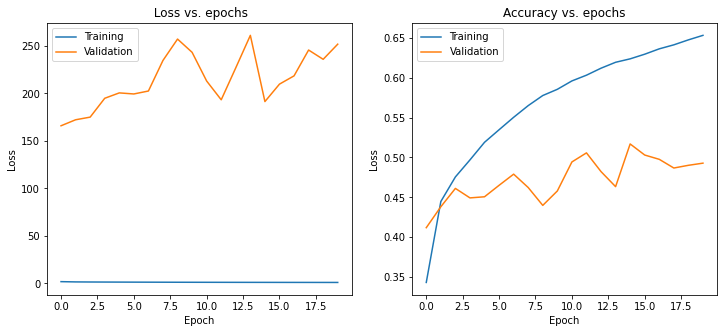

In [14]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

fig.add_subplot(122)

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

plt.show()

In [27]:
model_aug = get_model(input_shape = (32,32,3))
    
train_steps_per_epoch = train_generator_aug.n // train_generator_aug.batch_size
    
history_aug = model_aug.fit(train_generator_aug, steps_per_epoch=train_steps_per_epoch,
                  validation_data=test_generator_aug,
                  epochs=20,
                  callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=5)])

Epoch 1/20
5000/5000 [==============================] - 88s 18ms/step - loss: 2.0548 - categorical_accuracy: 0.2328 - val_loss: 1.9705 - val_categorical_accuracy: 0.2764
Epoch 2/20
5000/5000 [==============================] - 87s 17ms/step - loss: 1.9477 - categorical_accuracy: 0.2804 - val_loss: 1.9147 - val_categorical_accuracy: 0.2873
Epoch 3/20
5000/5000 [==============================] - 88s 18ms/step - loss: 1.9050 - categorical_accuracy: 0.2932 - val_loss: 1.9425 - val_categorical_accuracy: 0.2840
Epoch 4/20
5000/5000 [==============================] - 88s 18ms/step - loss: 1.8655 - categorical_accuracy: 0.3104 - val_loss: 1.8279 - val_categorical_accuracy: 0.3332
Epoch 5/20
5000/5000 [==============================] - 88s 18ms/step - loss: 1.8361 - categorical_accuracy: 0.3237 - val_loss: 1.8063 - val_categorical_accuracy: 0.3373
Epoch 6/20
5000/5000 [==============================] - 88s 18ms/step - loss: 1.8092 - categorical_accuracy: 0.3365 - val_loss: 1.7913 - val_categoric

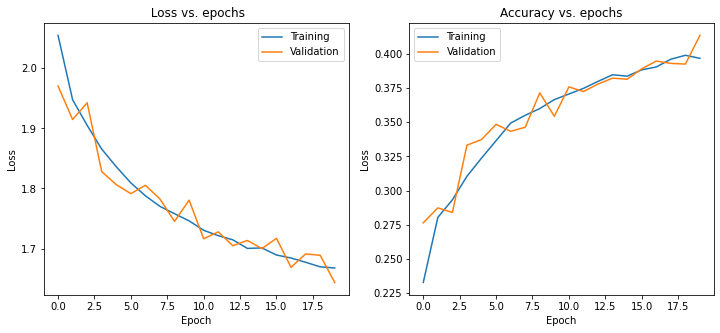

In [28]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title(' Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

fig.add_subplot(122)

plt.plot(history_aug.history['categorical_accuracy'])
plt.plot(history_aug.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

plt.show()

## Predictions

In [29]:
predictions = model_aug.predict(test_generator_aug, steps=1)
print(np.round(predictions, 2))

[[0.1  0.24 0.07 0.1  0.05 0.07 0.02 0.11 0.12 0.13]
 [0.02 0.72 0.   0.   0.   0.   0.   0.   0.02 0.24]
 [0.16 0.11 0.06 0.07 0.09 0.02 0.08 0.02 0.3  0.1 ]
 [0.14 0.01 0.32 0.14 0.08 0.15 0.04 0.09 0.02 0.01]
 [0.01 0.   0.13 0.28 0.04 0.33 0.09 0.1  0.   0.01]
 [0.46 0.04 0.03 0.02 0.02 0.02 0.   0.01 0.34 0.06]
 [0.01 0.05 0.02 0.16 0.03 0.15 0.04 0.27 0.01 0.28]
 [0.01 0.   0.43 0.06 0.14 0.15 0.14 0.07 0.   0.  ]
 [0.   0.   0.04 0.37 0.01 0.38 0.18 0.01 0.   0.  ]
 [0.01 0.   0.09 0.06 0.24 0.05 0.51 0.03 0.   0.  ]]


## References:

- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://keras.io/api/preprocessing/image/